In [1]:
import numpy as np
import gc
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
LIDAR_RANGE = 100
Z_THRESHOLD = 2
Z_THRESHOLD /= LIDAR_RANGE

In [3]:
STATIC_PREPROCESS_DATA_PATH  =  "../training_data/small_map/dynamic_high_med_ped/static_prepreprocess_dir"
DYNAMIC_PREPROCESS_DATA_PATH = "../training_data/small_map/dynamic_high_med_ped/dynamic_prepreprocess_dir"

In [4]:
def getint(name):
    try:
        return int(name.split('.')[0])
    except Exception as e:
        print("Error occured while trying to read {}".format(name))
    return None

In [5]:
val_file  =   sorted(os.listdir( STATIC_PREPROCESS_DATA_PATH), key=getint)[-1]

In [6]:
with open(os.path.join(STATIC_PREPROCESS_DATA_PATH, val_file), 'rb') as pkl_file:
    static_dataset_val = pickle.load(pkl_file)

In [7]:
with open(os.path.join(DYNAMIC_PREPROCESS_DATA_PATH, val_file), 'rb') as pkl_file:
    dynamic_dataset_val = pickle.load(pkl_file)

In [8]:
gc.collect()

0

In [9]:
static_dataset_val.shape, dynamic_dataset_val.shape

((2460, 2, 16, 1024), (2460, 2, 16, 1024))

In [10]:
(static_dataset_val - dynamic_dataset_val).shape

(2460, 2, 16, 1024)

In [11]:
z_val = dynamic_dataset_val[:,1].reshape((dynamic_dataset_val.shape[0],
                                          1,
                                          dynamic_dataset_val.shape[2],
                                          dynamic_dataset_val.shape[3]))
z_val.shape

(2460, 1, 16, 1024)

In [12]:
loss_wt = np.ones(dynamic_dataset_val.shape)
loss_wt.shape

(2460, 2, 16, 1024)

In [13]:
z_mask = z_val > Z_THRESHOLD
z_mask = np.concatenate((z_mask, z_mask), axis=1)
z_mask.shape

(2460, 2, 16, 1024)

In [14]:
loss_wt[z_mask] = 5

In [15]:
def recon_loss_fn(recon, static):
    LIDAR_RANGE = 100
    Z_THRESHOLD = 2
    Z_THRESHOLD /= LIDAR_RANGE
    
    z_val = static[:,1].reshape((static.shape[0],1,static.shape[2],static.shape[3]))
    z_mask = z_val > Z_THRESHOLD
    z_mask = np.concatenate((z_mask, z_mask), axis=1)
    
    loss_wt = np.ones(static_dataset_val.shape)
    loss_wt[z_mask] = 5
    
    total_loss = ((recon - static) * loss_wt).abs().sum(-1).sum(-1).sum(-1)
    return total_loss

In [16]:
dynamic_dataset_val[z_mask] = 0

In [17]:
def from_polar_np(velo):
    angles = np.linspace(0, np.pi * 2, velo.shape[-1])
    dist, z = velo[:, 0], velo[:, 1]
    x = np.cos(angles) * dist
    y = np.sin(angles) * dist
    out = np.stack([x,y,z], axis=1)
    return out.astype('float32')

In [18]:
dynamic_dataset_val.shape

(2460, 2, 16, 1024)

In [19]:
some_arr = from_polar_np(dynamic_dataset_val)[0]
some_arr.shape

(3, 16, 1024)

In [20]:
import open3d as o3d
import copy
import matplotlib.pyplot as plt
import transforms3d

def draw_registration_result(src_pcd, dst_pcd, x_pt, y_pt, theta):    
    src_pcd_tmp = copy.deepcopy(src_pcd)
    dst_pcd_tmp = copy.deepcopy(dst_pcd)
    
    src_pcd_tmp.paint_uniform_color([1, 0, 0])  # red source
    dst_pcd_tmp.paint_uniform_color([0, 0, 1])  # blue target
    
    transform_mat = pose2matrix([x_pt, y_pt, 0], [0,0,theta])
    dst_pcd_tmp.transform(transform_mat)
    
    visualizer = o3d.JVisualizer()
    visualizer.add_geometry(src_pcd_tmp)
    visualizer.add_geometry(dst_pcd_tmp)
    visualizer.show()
    
def draw_pcd(pcd, where='opn_nb'):
    if where is 'opn_nb':
        visualizer = o3d.JVisualizer()
        visualizer.add_geometry(pcd)
        visualizer.show()
    elif where is 'opn_view':
        o3d.visualization.draw_geometries([pcd], width=1280, height=800)
    elif where is 'mat_3d':
        plt.figure()
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1], pts[:,2])
        plt.grid()
        plt.show()
    elif where is 'mat_2d':
        plt.figure()
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1])
        plt.grid()
        plt.show()

def pose2matrix(translation_list, rotation_angle_list):
    trans_vec = np.array(translation_list)
    rot_ang = [np.deg2rad(ang) for ang in rotation_angle_list ]
    rot_mat = transforms3d.euler.euler2mat(rot_ang[0], rot_ang[1], rot_ang[2])
    zoom = np.ones(3)
    transform_mat = transforms3d.affines.compose(trans_vec, rot_mat, zoom)
    return transform_mat

In [21]:
some_pcd =  o3d.geometry.PointCloud()
some_pcd.points = o3d.utility.Vector3dVector(some_arr.reshape(3,-1).T)

In [22]:
draw_pcd(some_pcd)

JVisualizer with 1 geometries

In [23]:
%matplotlib notebook

<IPython.core.display.Javascript object>


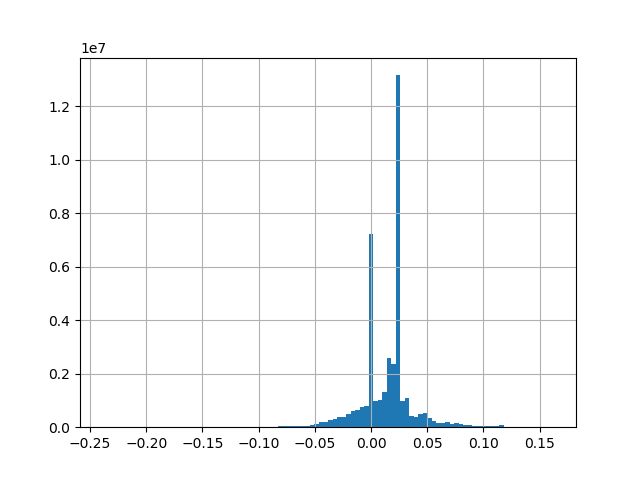

(array([1.0000000e+00, 4.0000000e+00, 3.4700000e+02, 4.5100000e+02,
        4.5000000e+02, 1.6100000e+02, 2.6200000e+02, 3.0600000e+02,
        1.2000000e+03, 3.5000000e+02, 1.6310000e+03, 4.4940000e+03,
        3.3150000e+03, 1.4390000e+03, 4.3430000e+03, 3.7900000e+03,
        4.0260000e+03, 1.8690000e+03, 5.5230000e+03, 3.8530000e+03,
        3.6260000e+03, 4.0940000e+03, 7.0490000e+03, 6.8570000e+03,
        1.1480000e+04, 3.5780000e+03, 3.1690000e+03, 4.8990000e+03,
        5.7680000e+03, 4.4020000e+03, 1.4008000e+04, 1.5326000e+04,
        1.2936000e+04, 6.7680000e+03, 1.2054000e+04, 9.4220000e+03,
        1.4933000e+04, 2.0826000e+04, 2.4690000e+04, 2.7418000e+04,
        3.8647000e+04, 4.4413000e+04, 2.8256000e+04, 5.2764000e+04,
        5.2690000e+04, 5.9904000e+04, 8.9237000e+04, 1.3203400e+05,
        1.7825100e+05, 2.0647800e+05, 2.6551000e+05, 2.9475400e+05,
        3.8794100e+05, 3.8376400e+05, 4.8608800e+05, 6.2063100e+05,
        6.3034100e+05, 7.4405200e+05, 7.9376600e

In [24]:
plt.grid()
plt.hist(static_dataset_val[:,1].flatten(), 100)